<a href="https://colab.research.google.com/github/nadjazivkovic03/thesis/blob/main/2024_Practical_Session_8_Level_Sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session 8 - Active contour using level sets

$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\norm}[1]{\|#1\|}$



In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import pylab
from skimage.color import rgb2gray

In [73]:
# Run this the first time you laun_ch the kernel on Colab.
# !git clone https://github.com/AgatheSenellart/DataMAA308.git
# !mv DataMAA308/data data
# !mv DataMAA308/Images Images

In this practical session, we guide you through implementing a method of *active contour segmentation* using level sets.
In the level set formalism, a contour or a curve $ (\gamma(t))_{t=0}^1 $
corresponds to the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\gamma(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$

We modify the contours by modifying the level function $\phi$.

First we introduce some plotting functions.


# Plotting functions

In [74]:
def plot_level_set(Z,f=None,level=0):
    """
    Plots the level set of the function f on Z.

    Args :
        Z (array n_r,n_c) : The grid/image or domain we work on.
        f (array n_r,n_c) : The values of the function on the domain given by Z.
            If None is provided, f is taken equal to Z.
        level (float) : The level of the function f we want to visualize. Default to 0.
    f, Z : (n_r,n_c)
    """
    if f is None:
        f = np.copy(Z)

    n,p = np.shape(Z)
    X,Y = np.meshgrid(np.arange(0,p),np.arange(0,n))
    plt.contour(X, Y, f,[level],linewidths=2, colors="red")
    img_plot = plt.imshow(Z, interpolation='nearest')
    img_plot.set_cmap('gray')
    pylab.axis('off')


def rescale(f,a=0,b=1):
    """
        Rescale linearly the dynamic of a vector to fit within a range [a,b]
    """
    v = f.max() - f.min()
    g = (f - f.min()).copy()
    if v > 0:
        g = g / v
    return a + g*(b-a)

# Importation of images

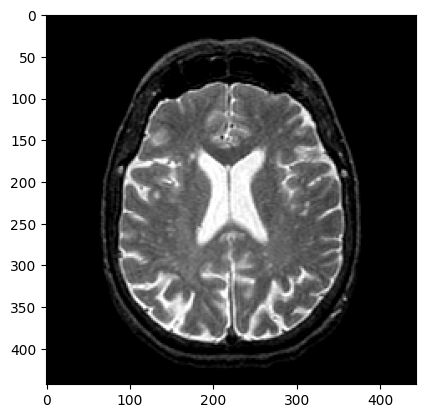

In [75]:
anchor = mpimg.imread('Images/image_redanch.jpg')
cortex = rescale(mpimg.imread('Images/cortex.bmp'))
I = cortex
Im_gray = rgb2gray(I)
n_r,n_c= Im_gray.shape
plt.imshow(Im_gray,cmap='gray')
plt.show()

# Mean curvature motion

<!-- The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\gamma'(s)} d s. $$ -->
We consider a first way to update a level function $\phi : \mathbb R^2 \to \mathbb R$ to try and fit our segmentation.

In the mean curvature motion, the evolution of the level function $\phi_t$ for $t \geq 0$ is given by
the following PDE
$$\pd{\phi_t}{t} = G(\phi_t)$$
with $G : \mathcal F(\mathbb R^2, \mathbb R) \to F(\mathbb R^2, \mathbb R)$ given by the expression :
  $$G(\phi) = \norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }$$
and where $\nabla \phi_t(x) \in \RR^2$ is the spatial gradient.


This flow is computed using Euler's method :
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} + \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step. We choose the maximum time $t_{max} \geq 0$ for which we stop iterating.

**This first method allows you to implement important functions you will need in Geodesic Active Contour part, and code the core of the full algorithm. \
But here, as the algorithm does not take into account the image during the minimization process, you consider that your initial $\phi^0$ depends on $I_0$.**


**TODO 1** : Implement the `spatial_gradient` and div functions that computes the gradient of the level_set function and the divergence of a vector field.

In [76]:
def spatial_gradient(M):
    """Computes the gradient of the level set function M.

    Args:
        M (array n_r,n_c): The level function defined on a grid n_rxn_c.

    Returns:
        gx array n_r,n_c : The derivate of M with respect to the first coordinate (x).
        gy array n_r,n_c : The derivate of M with respect to the second coordinate (y).

    """

    gx = np.gradient(M, axis=1)
    gy = np.gradient(M, axis=0)
    gx [:, 0] = M[:, 1] - M[:, 0]
    gx [:, -1] = M[:, -1] - M[:, -2]
    gy [0, :] = M[1, :] - M[0, :]
    gy [-1, :] = M[-1, :] - M[-2, :]

    return gx, gy



def div(Px,Py):
    """
    Computes the divergence of a vector field defined on a grid.

    Args:
        Px (array n_r,n_c): The value of the first coordinate of the vector field in each point of the grid n_r,n_c.
        Py (array n_r, n_c): The value of the second coordinate of the vector field in each point of the grid n_r,n_c.

    Returns:
        d (array n_r,n_c) : The value of the divergence in each point of the grid.
    """


    dPx = np.gradient(Px, axis=1)
    dPy = np.gradient(Py, axis=0)
    dPx [0, :] = 0
    dPx [:, -1] = 0
    dPy [0, :] = 0
    dPy [:, -1] = 0

    return dPx + dPy


**TODO 2** : Implement the function G.

In [77]:
def G_mean_curvature(phi):
    """Implement the G function described above for a level set phi.

    Args:
        phi (array n_r,n_c): The level function values on a grid n_r,n_c.

    Returns:
        G array n_r,n_c : The G function values on the grid n_r,n_c.
    """

    dx, dy = spatial_gradient(phi)
    eps = 1e-10
    norm = np.ones(dx.shape)*eps + np.sqrt(dx**2 + dy**2)

    return div(dx/norm,dy/norm)*norm

**TODO 3** : Complete the gradient descent function that computes the iterations of the level set $\phi_t, 0 \leq t \leq t_{max}$.

In [78]:
def euler_mean_curvature(phi0,tau,T_max,I0):
    '''
    Args :
        phi0 (array n_r,n_c) : The inial level function.
        tau (float) : time step size, > 0, be careful to not have a too big time step !
        T_max (int): maximum time of the evolution
        I0 (array n_r,n_c): your gray image to segment
    ------
    returns
        final_phi (array n_r,n_c)

    '''
    phi = phi0
    T = 0
    while (T <= T_max):
        phi1 = phi + tau*G_mean_curvature(phi)
        phi = phi1
        T += tau

    return phi


## Application
Let's test your implementation on a simple example. Below we create an artificial image `phi_3`.

In [79]:
n_r = 200
n_c = 300
Y,X = np.meshgrid(np.arange(1,n_c+1), np.arange(1,n_r+1))

r = n_r/4.
c = np.asarray([n_c,n_c])/4.
phi_1 = (np.maximum(abs(X-c[0]), abs(Y-c[1]))-r)


r = n_r/4.
c = np.asarray([n_c,n_c])/2.1
phi_2 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

phi_3 = np.minimum(phi_1, phi_2)

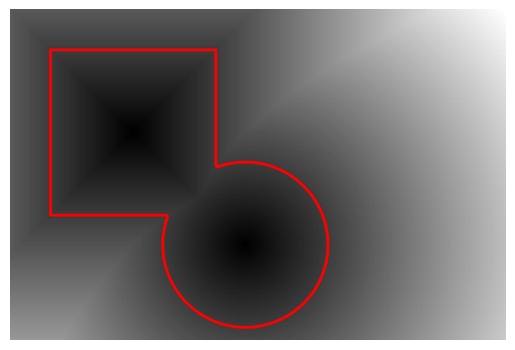

In [80]:
# Plots the image and the natural level set given by the image intensity
plot_level_set(phi_3, f=phi_3)

**TODO 4: Execute your algorithm on the "image" $\phi^3$ given above.\
Then change initial $\phi^0$ and see what happens.**

In [81]:
tau = 0.4
T_max = 200

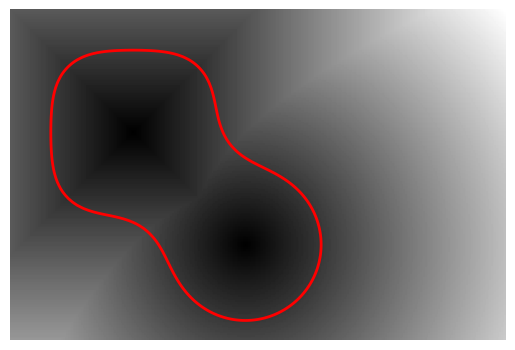

In [82]:
phi = euler_mean_curvature(phi_3,tau,T_max,phi_3)
plot_level_set(Z = phi_3,f = phi)

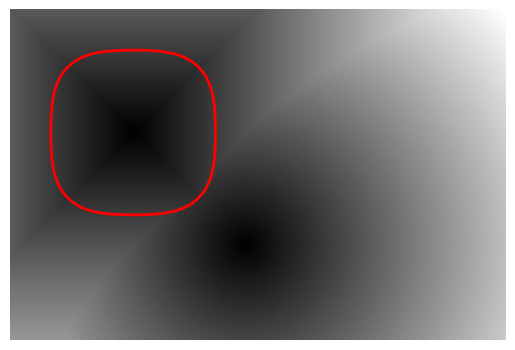

In [83]:
phi = euler_mean_curvature(phi_1,tau,T_max,phi_3)
plot_level_set(Z = phi_3,f = phi)

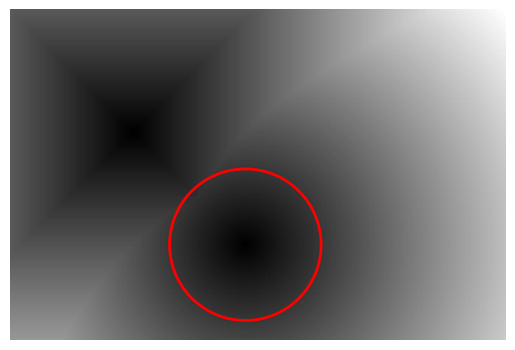

In [84]:
phi = euler_mean_curvature(phi_2,tau,T_max,phi_3)
plot_level_set(Z = phi_3,f = phi)

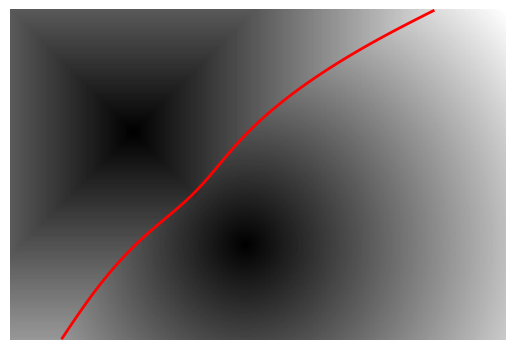

In [85]:
phi = euler_mean_curvature(phi_1-phi_2,tau,T_max,phi_3)
plot_level_set(Z = phi_3,f = phi)

# Geodesic Active Contour

In the Mean Curvature Motion, the evolution of the curve does not depend on the image ! Only the initial level function $\phi_0$ can be chosen to fit the image and the Mean Curvature Motion "smoothes" the contour. Now we see a more segmentation method that makes use of the image to update the level functions $\phi_t$ depending on the image gradient.
This method re-uses functions implemented in the first part.

Geodesic active contours compute local minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.

Given a background image $I_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of small gradient.


We use here
$$W(x) = \alpha + \frac{\beta}{\epsilon + d_0(x) }
      \qwhereq d_0(x) = \norm{\nabla I_0(x)} $$




The geodesic active contour minimizes a weighted length of curve
$$\underset{\gamma}{min} \int_0^1 \norm{\gamma'(s)} W(\gamma(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = \norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using an Euler method.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} + \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.




Define an initial $\phi^0$. You can plot, together with your image Im_gray, with plot_levels function.\
Here your $\phi^0$ is not equal to your image $I_0$ !

In [86]:
n_r,n_c = Im_gray.shape
Y,X = np.meshgrid(np.arange(1,n_c+1), np.arange(1,n_r+1))
r = n_r/3.
c = np.asarray([n_c,n_c])/2.
phi0 = np.maximum(abs(X-c[0]), abs(Y-c[1])) - 1*r # Scaling r to not cut the brain

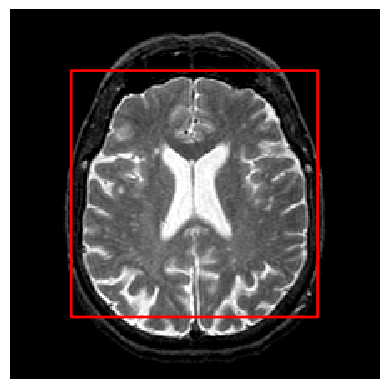

In [87]:
plot_level_set(Im_gray,f=phi0)

**TODO 5** : Compute $W$ and plot it to see how it looks.

$$W(x) = \alpha + \frac{\beta}{\epsilon + d_0(x) }
      \qwhereq d_0(x) = \norm{\nabla I_0(x)} $$

In [88]:
def compute_W(I):
    dx, dy = spatial_gradient(I)
    d0 = np.sqrt(dx**2 + dy**2)
    alpha = 1.0
    beta = 1.0
    epsilon = 0.5
    return alpha + beta / (epsilon + d0)

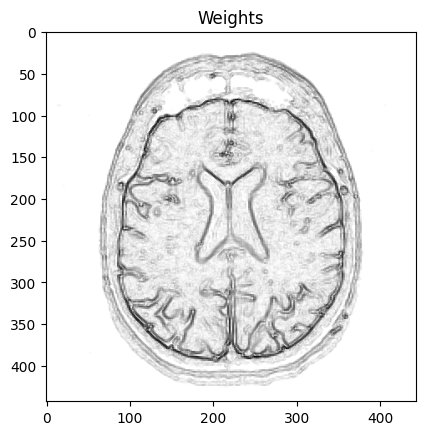

In [89]:
plt.figure()
plt.imshow(compute_W(Im_gray),cmap='gray')
plt.title('Weights')
plt.show()

**TODO 6** : Implement the function `G_geodesic` that implements the $G$ function described above for the Geodesic Active Contours method.

In [90]:
def G_geodesic(phi,W):
    """Implement the G function described above for a level set phi.

    Args:
        phi (array n_r,n_c): The level function values on a grid n_r,n_c.
        W (array n_r,n_c) : The edge stopping function

    Returns:
        G array n_r,n_c : The G function values on the grid n_r,n_c.
    """
    dx, dy = spatial_gradient(phi)
    norm = np.linalg.norm(np.gradient(phi), axis=0)
    norm[norm < 10e-6] = 10e-6
    G = div(W*dx/norm, W*dy/norm)*norm
    return G

**TODO 7** In a similar fashion as `euler_mean_curvature`, implement `euler_geodesics`that computes the evolution in time of $\phi$ as given by the equations above.

In [91]:
def euler_geodesics(phi0,tau,T_max,I0,W):
    '''
    Args :
        phi0 (array n_r,n_c) : The inial level function.
        tau (float) : time step size, > 0, be careful to not have a too big time step !
        T_max (int): maximum time of the evolution
        I0 (array n_r,n_c): your gray image to segment,
        W (array n_r,n_c): The edge stopping function.
    ------
    returns
        final_phi (array n_r,n_c)

    '''
    phi = phi0
    T = 0
    while (T <= T_max):
        phi1 = phi + tau*G_geodesic(phi, W)
        phi = phi1
        T += tau

    return phi

## Application

**TODO 8** :
Run the geodesic method on `Im_gray`.
Depending on the image you want to segment, and your initial $\phi^0$, you may need a huge number of iterations to see significative modifications of your contour.

In [92]:
tau = 0.25
T_max = 1000

phi = euler_geodesics(phi0,tau,T_max,Im_gray,compute_W(Im_gray))

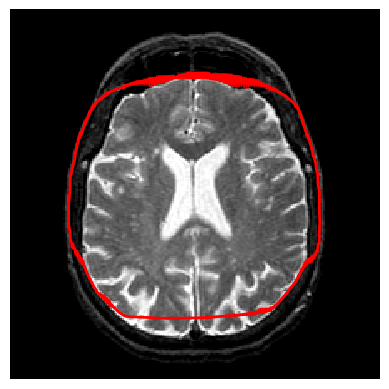

In [93]:
plot_level_set(Im_gray,phi)